In [52]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_pickle('datasets/total.pkl')

df.head()

,date,month,day,year,time,north_avenue_entry,north_avenue_exit,quezon_avenue_entry,quezon_avenue_exit,gma_kamuning_entry,...,guadalupe_entry,guadalupe_exit,buendia_entry,buendia_exit,ayala_avenue_entry,ayala_avenue_exit,magallanes_entry,magallanes_exit,taft_entry,taft_exit
0,2014-01-01,1,1,2014,03:00,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-01-01,1,1,2014,04:00,74,0,24,0,20,...,3,0,0,0,0,0,0,0,0,0
2,2014-01-01,1,1,2014,05:00,525,88,191,47,121,...,128,104,51,114,124,333,84,121,417,307
3,2014-01-01,1,1,2014,06:00,663,601,344,310,187,...,376,285,185,179,489,604,334,198,935,822
4,2014-01-01,1,1,2014,07:00,831,965,358,436,231,...,458,418,239,200,467,847,458,274,1240,1477


In [53]:
df.columns

Index(['date', 'month', 'day', 'year', 'time', 'north_avenue_entry',
       'north_avenue_exit', 'quezon_avenue_entry', 'quezon_avenue_exit',
       'gma_kamuning_entry', 'gma_kamuning_exit', 'cubao_entry', 'cubao_exit',
       'santolan_entry', 'santolan_exit', 'ortigas_entry', 'ortigas_exit',
       'shaw_blvd_entry', 'shaw_blvd_exit', 'boni_avenue_entry',
       'boni_avenue_exit', 'guadalupe_entry', 'guadalupe_exit',
       'buendia_entry', 'buendia_exit', 'ayala_avenue_entry',
       'ayala_avenue_exit', 'magallanes_entry', 'magallanes_exit',
       'taft_entry', 'taft_exit'],
      dtype='object')

### Preprocess dataset into a univariate time series (daily ridership)

In [54]:
df['total'] = df.iloc[:, 5:].sum(axis=1)
df = df.groupby('date').agg({'total': np.sum}).reset_index()

data = df['total']

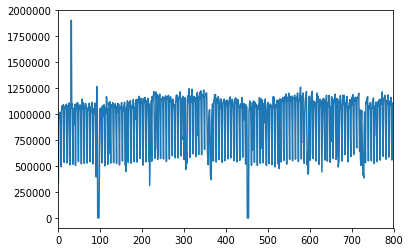

In [122]:
data[0:800].plot()

We can use up to the first 800 elements in the sequence

Possible partition:
* 500 training
* 200 validation
* 100 testing

### Importing

In [5]:
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

### Data preparation

In [139]:
data_raw = [[x] for x in data.values.astype('float32')[0:800]]
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(data_raw)

dataset[0:5]

array([[0.17812781],
       [0.45181248],
       [0.52252956],
       [0.53211469],
       [0.53391426]])

In [140]:
train_size = 500
val_size = 200
test_size = 100

train, val, test = dataset[0:train_size, :], dataset[train_size:train_size+val_size, :], dataset[train_size+val_size:len(dataset), :]
print("Size of (train, val, test) sets: ({}, {}, {})".format(len(train), len(val), len(test)))

Size of (train, val, test) sets: (500, 200, 100)


We should reformat the data to include the previous and then the next in the sequence

In [141]:
def create_dataset(data):
    return (data[0:-1], np.roll(data, -1)[0:-1])

In [142]:
train_X, train_Y = create_dataset(train)
val_X, val_Y = create_dataset(val)
test_X, test_Y = create_dataset(test)

# reshape data for Keras

train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
val_X = np.reshape(val_X, (val_X.shape[0], 1, val_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape)

(499, 1, 1)


### Basic Model

In [144]:
def fit_model(train_X, train_Y, val_X, val_Y, window_size=1):
    model = tf.keras.Sequential()
    
    model.add(layers.LSTM(8,
                          input_shape=(1,window_size)))
    model.add(layers.Dense(1))
    model.compile(loss="mean_squared_error",
                 optimizer="adam")
    
    model.fit(train_X,
             train_Y,
             epochs=20,
             batch_size=1,
             validation_data=(val_X, val_Y))
    
    return model

In [145]:
model = fit_model(train_X, train_Y, val_X, val_Y)

Train on 499 samples, validate on 199 samples
Epoch 1/20
499/499 [==============================] - 4s 7ms/sample - loss: 0.0483 - val_loss: 0.0145
Epoch 2/20
499/499 [==============================] - 1s 2ms/sample - loss: 0.0162 - val_loss: 0.0146
Epoch 3/20
499/499 [==============================] - 1s 2ms/sample - loss: 0.0163 - val_loss: 0.0145
Epoch 4/20
499/499 [==============================] - 1s 2ms/sample - loss: 0.0162 - val_loss: 0.0145
Epoch 5/20
499/499 [==============================] - 1s 2ms/sample - loss: 0.0162 - val_loss: 0.0146
Epoch 6/20
499/499 [==============================] - 1s 2ms/sample - loss: 0.0163 - val_loss: 0.0146
Epoch 7/20
499/499 [==============================] - 1s 2ms/sample - loss: 0.0163 - val_loss: 0.0148
Epoch 8/20
499/499 [==============================] - 1s 2ms/sample - loss: 0.0163 - val_loss: 0.0146
Epoch 9/20
499/499 [==============================] - 1s 2ms/sample - loss: 0.0161 - val_loss: 0.0145
Epoch 10/20
499/499 [===============

In [146]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 8)                 320       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [148]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform(Y)
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, np.concatenate([train_X, val_X, test_X]), np.concatenate([train_Y, val_Y, test_Y]))

print("Training data score: %.2f RMSE" % (rmse_train / len(train_X)))
print("Test data score: %.2f RMSE" % (rmse_test / 800))

Training data score: 494.34 RMSE
Test data score: 302.48 RMSE


In [156]:
train_Y[0:10]

array([[0.45181248],
       [0.52252956],
       [0.53211469],
       [0.53391426],
       [0.53460334],
       [0.47006957],
       [0.2583555 ],
       [0.54652649],
       [0.56741025],
       [0.55794163]])

In [154]:
model.predict(train_X)[0:10]

array([[0.36168414],
       [0.4552391 ],
       [0.47938424],
       [0.48264915],
       [0.48326182],
       [0.48349643],
       [0.46148092],
       [0.38901773],
       [0.48755383],
       [0.49465138]], dtype=float32)

### Plot predictions

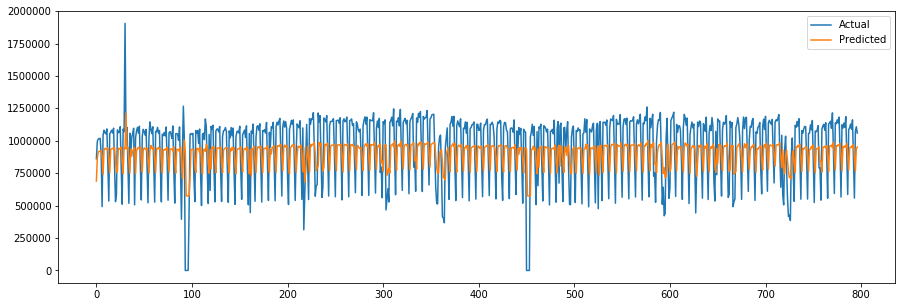

In [151]:
# training predictions
plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(np.concatenate([train_Y, val_Y, test_Y])), label="Actual")
plt.plot(test_predict, label="Predicted")
plt.legend()